# Offline Phase: generation of the POD modes

**Aim of the tutorial:** this notebook shows how to perform the offline phase of the POD algorithm, i.e. how to use this method to generate the basis functions from a parametric dataset.

When dealing with a new dataset, the POD should always be performed to assess how the eigenvalues decay, to determine whether or not the dataset can be approximated by a low-rank model.

----

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable).

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store
from pyforce.tools.functions_list import FunctionsList

import matplotlib.pyplot as plt
from matplotlib import cm

path='./Offline_results/'
if not os.path.exists(path):
    os.makedirs(path)

The geometry can be either generated directly in this notebook or loaded from a file.

**Disclaimer**: we have noticed that the degrees of freedom (dofs) of the mesh can vary according to the adopted operating system. This is due to the fact that the mesh is generated through the `gmsh` library, which can produce different results on different platforms. 

*If an error occurs, please check the number of dofs and adjust the code accordingly: if the snapshots have been downloaded from [Zenodo](https://zenodo.org/records/11483677) it is suggested to load the `msh` file; otherwise, if the snapshots hase been generated locally, the `use_msh` option must be set to `False`.*

In [2]:
from neutronics import create_anl11a2_mesh

domain, _, _ = create_anl11a2_mesh(use_msh=True, save_mesh=False)

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures. The snapshots live in a functional space: piecewise linear functions.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

Defining the variables to load

In [4]:
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

Let us load the train snapshots and the associated parameters describing the state.

In [6]:
path_FOM = './Snapshots/'

train_snaps = list()

for field_i in range(len(var_names)):
    train_snaps.append(FunctionsList(V))

    tmp_FOM_list, _ = ImportH5(V, path_FOM+'train_snap_'+var_names[field_i], var_names[field_i])
    
    for mu in range(len(tmp_FOM_list)):
        train_snaps[field_i].append(tmp_FOM_list(mu))
    
    del tmp_FOM_list      

## POD algorithm

A list will be created for each POD with the indices consistent with the `var_names` variable, i.e., $0 = \phi_1,\; 1 = \phi_2$.

### Decay of the POD eigenvalues

The offline `POD` class is used to compute the POD eigenvalues, eigenvectors and associated modes (i.e., basis functions).

The description of this class has already been covered, we highlight the fact that the eigendecomposition can be also performed using the *scipy* library, as shown in the following cell by turning the option `use_scipy` to `True`.

In [7]:
from pyforce.offline.pod import POD

pod_data = [POD(train_snaps[field_i], var_names[field_i], 
                use_scipy=True, 
                verbose = True) 
            for field_i in range(len(var_names))]

Computing phi_1 correlation matrix: 390.000 / 390.00 - 0.268 s/it
Computing phi_2 correlation matrix: 390.000 / 390.00 - 0.218 s/it


Let us plot the eigenvalues

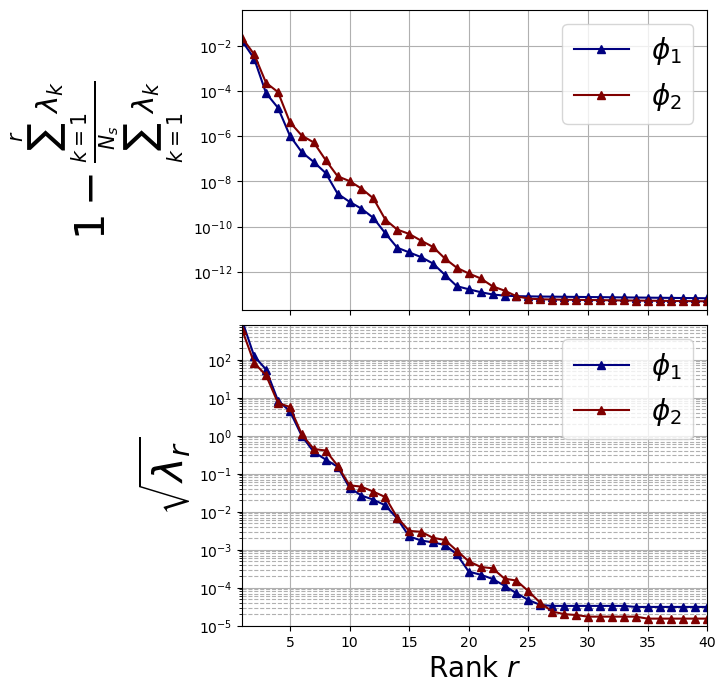

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

color = iter(cm.jet(np.linspace(0, 1, len(var_names))))

# Plot on the first subplot
for field_i in range(len(var_names)):
    c = next(color)
    axs[0].semilogy(
        np.arange(1, pod_data[field_i].eigenvalues.size + 1, 1),
        1 - np.cumsum(pod_data[field_i].eigenvalues) / sum(pod_data[field_i].eigenvalues),
        "-^", c=c, label="$" + tex_var_names[field_i] + "$", linewidth=1.5
    )
    
    axs[1].semilogy(
        np.arange(1, pod_data[field_i].eigenvalues[:40].size + 1, 1),
        np.sqrt(pod_data[field_i].eigenvalues[:40]),
        "-^", c=c, label="$" + tex_var_names[field_i] + "$", linewidth=1.5
    )

axs[0].set_ylabel(r"$1- \frac{\sum_{k=1}^{r}\lambda_k}{\sum_{k=1}^{N_s} \lambda_k}$", fontsize=30)
axs[0].set_ylim(2e-14, .4)

axs[1].set_ylabel(r"$\sqrt{\lambda_r}$", fontsize=30)
axs[1].set_ylim(1e-5, 800)

for ax in axs:
    ax.set_xticks(np.arange(0, 40 + 1, 5))
    ax.set_xlim(1, 40)
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.legend(fontsize=20)

axs[1].set_xlabel(r"Rank $r$", fontsize=20)
    
fig.subplots_adjust(hspace=0.05)

### Definition of the modes

$N_{max}=20$ has been chosen by analysing the decay of the eigenvalues.

In [12]:
Nmax = 20

for ii in range(len(var_names)):
    pod_data[ii].compute_basis(train_snaps[ii], Nmax, normalise = True)

Let us store the modes

In [13]:
if not os.path.exists(path+'BasisFunctions'):
    os.makedirs(path+'BasisFunctions')

for ii in range(len(var_names)):
    store(domain, pod_data[ii].PODmodes, 'POD_' +var_names[ii], path+'/BasisFunctions/basisPOD_' + var_names[ii])

### Computing the training error
Then, we need to assess the performance of the POD basis generated in the previous cells. The reduced coefficients $\alpha_m(\boldsymbol{\mu})$ can be obtained from the train snapshots using $L^2$ projection: given a function $u(\mathbf{x};\boldsymbol{\mu}_n)$ with $\boldsymbol{\mu}_n\in\Xi_{train}$, the reduced coefficients can be computed with

\begin{equation*}
\alpha_m(\boldsymbol{\mu}_n) = (\psi_m, u(\mathbf{x};\boldsymbol{\mu}_n))_{L^2(\Omega)} = \int_{\Omega} \psi_m\cdot u(\mathbf{x};\boldsymbol{\mu}_n)\,d\Omega
\end{equation*}

The method `train_error` computes the $L^2$ error between the original snapshots and the reconstructed ones using the POD basis functions: it takes as input the train snapshots and the maximum number of modes to consider.

In [14]:
train_PODcoeff = []

idx_algo = 0
train_abs_err = np.zeros((Nmax, len(var_names)))
train_rel_err = np.zeros((Nmax, len(var_names)))

for ii in range(len(var_names)):
    tmp = pod_data[ii].train_error(train_snaps[ii], Nmax, verbose = True)

    train_abs_err[:, ii] = tmp[0].flatten()
    train_rel_err[:, ii] = tmp[1].flatten()
    
    train_PODcoeff.append(tmp[2])

Computing train error phi_1: 390.000 / 390.00 - 0.060 s/it
Computing train error phi_2: 390.000 / 390.00 - 0.063 s/it


The max absolute and relative reconstruction error is compared for the different fields, given the following definitions
\begin{equation*}
\begin{split}
E_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_N$ the reconstruction operator with $N$ basis functions (takes the reduced coefficients generated by the $L^2$ projection and performs the linear combination of the modes).

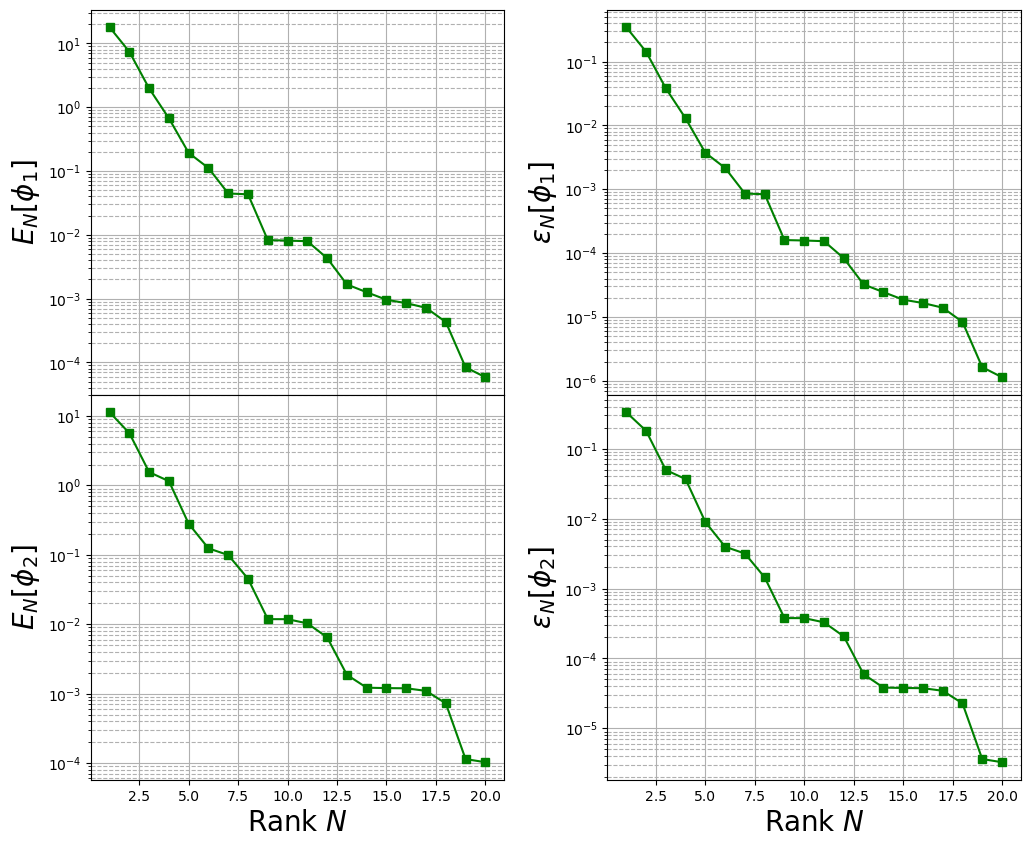

In [15]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (12,10) )

M = np.arange(1,Nmax+1,1)

for ii in range(len(var_names)):
    
    axs[ii, 0].semilogy(M, train_abs_err[:Nmax, ii], 'g-s',   label = r'POD')
    axs[ii, 1].semilogy(M, train_rel_err[:Nmax, ii], 'g-s',   label = r'POD')

    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Rank $N$",fontsize=20)
axs[1, 1].set_xlabel(r"Rank $N$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')   

TrainingErrFig.subplots_adjust(hspace = 0, wspace=0.25)

## Post Process: plotting the POD modes
In this last section, *pyvista* is used to make some contour plots of the POD modes for both fluxes.

Let us plot the first 6 POD modes of each variable: in particular, contour plots of the fast and thermal flux are shown.

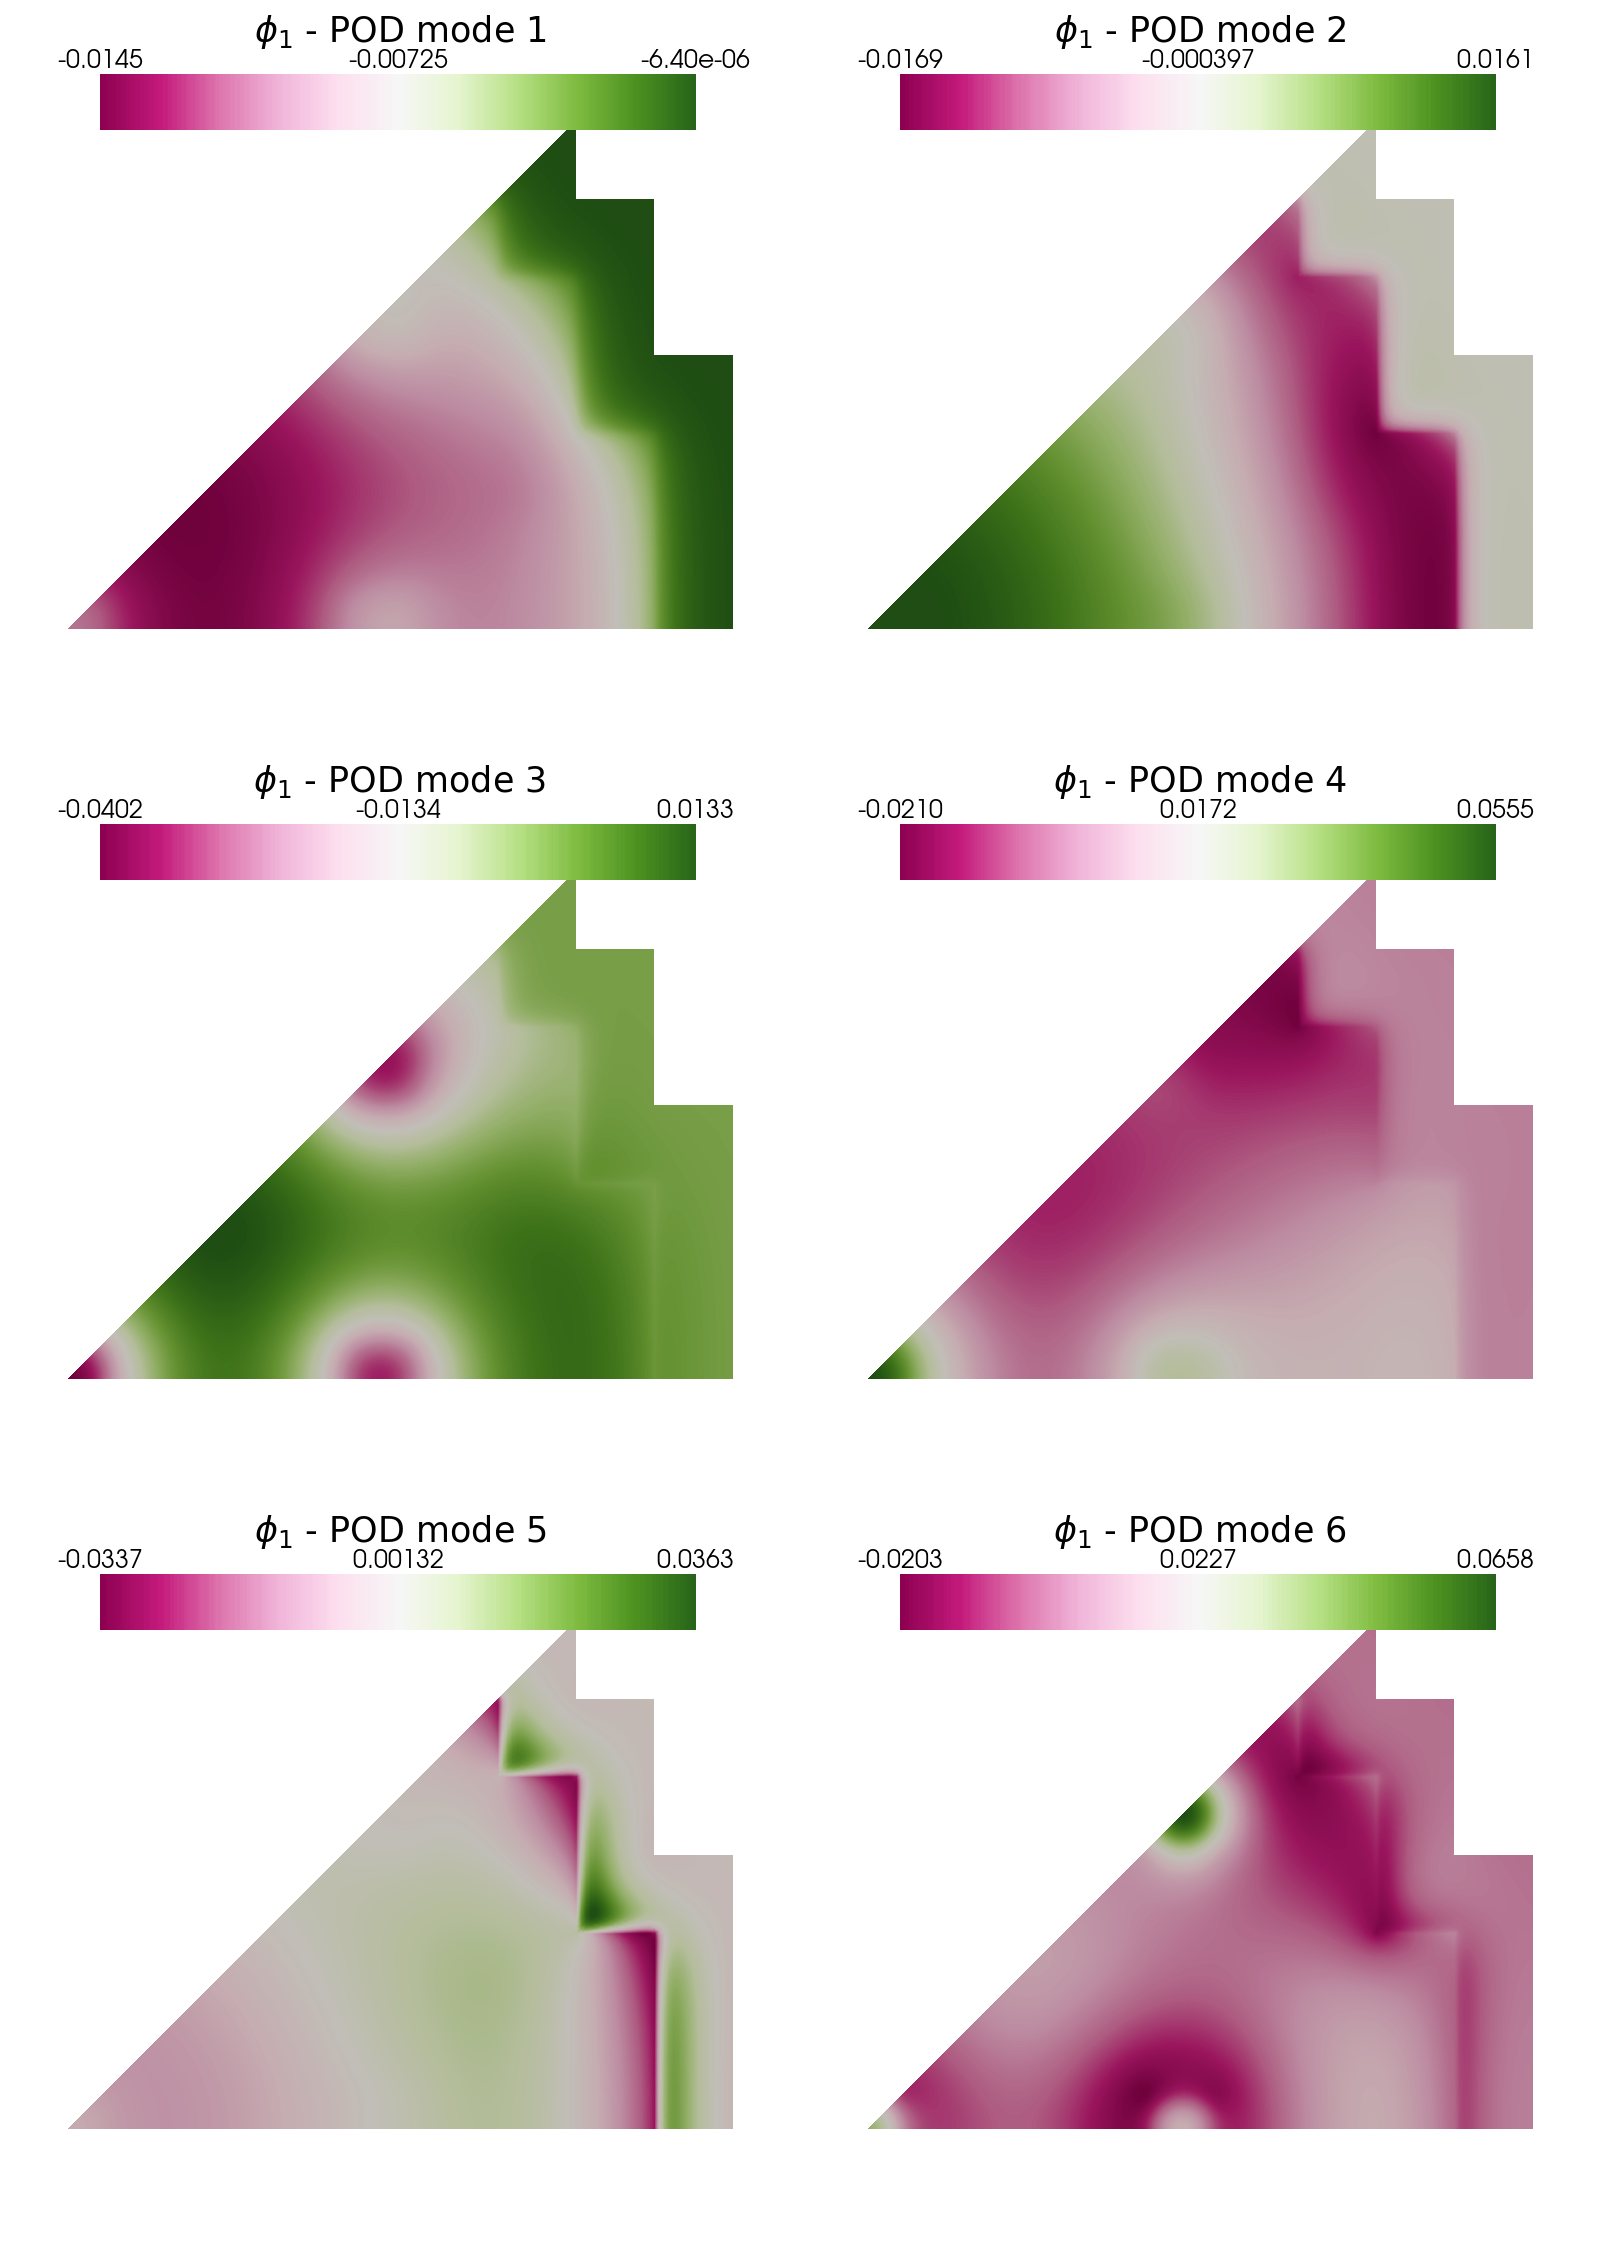

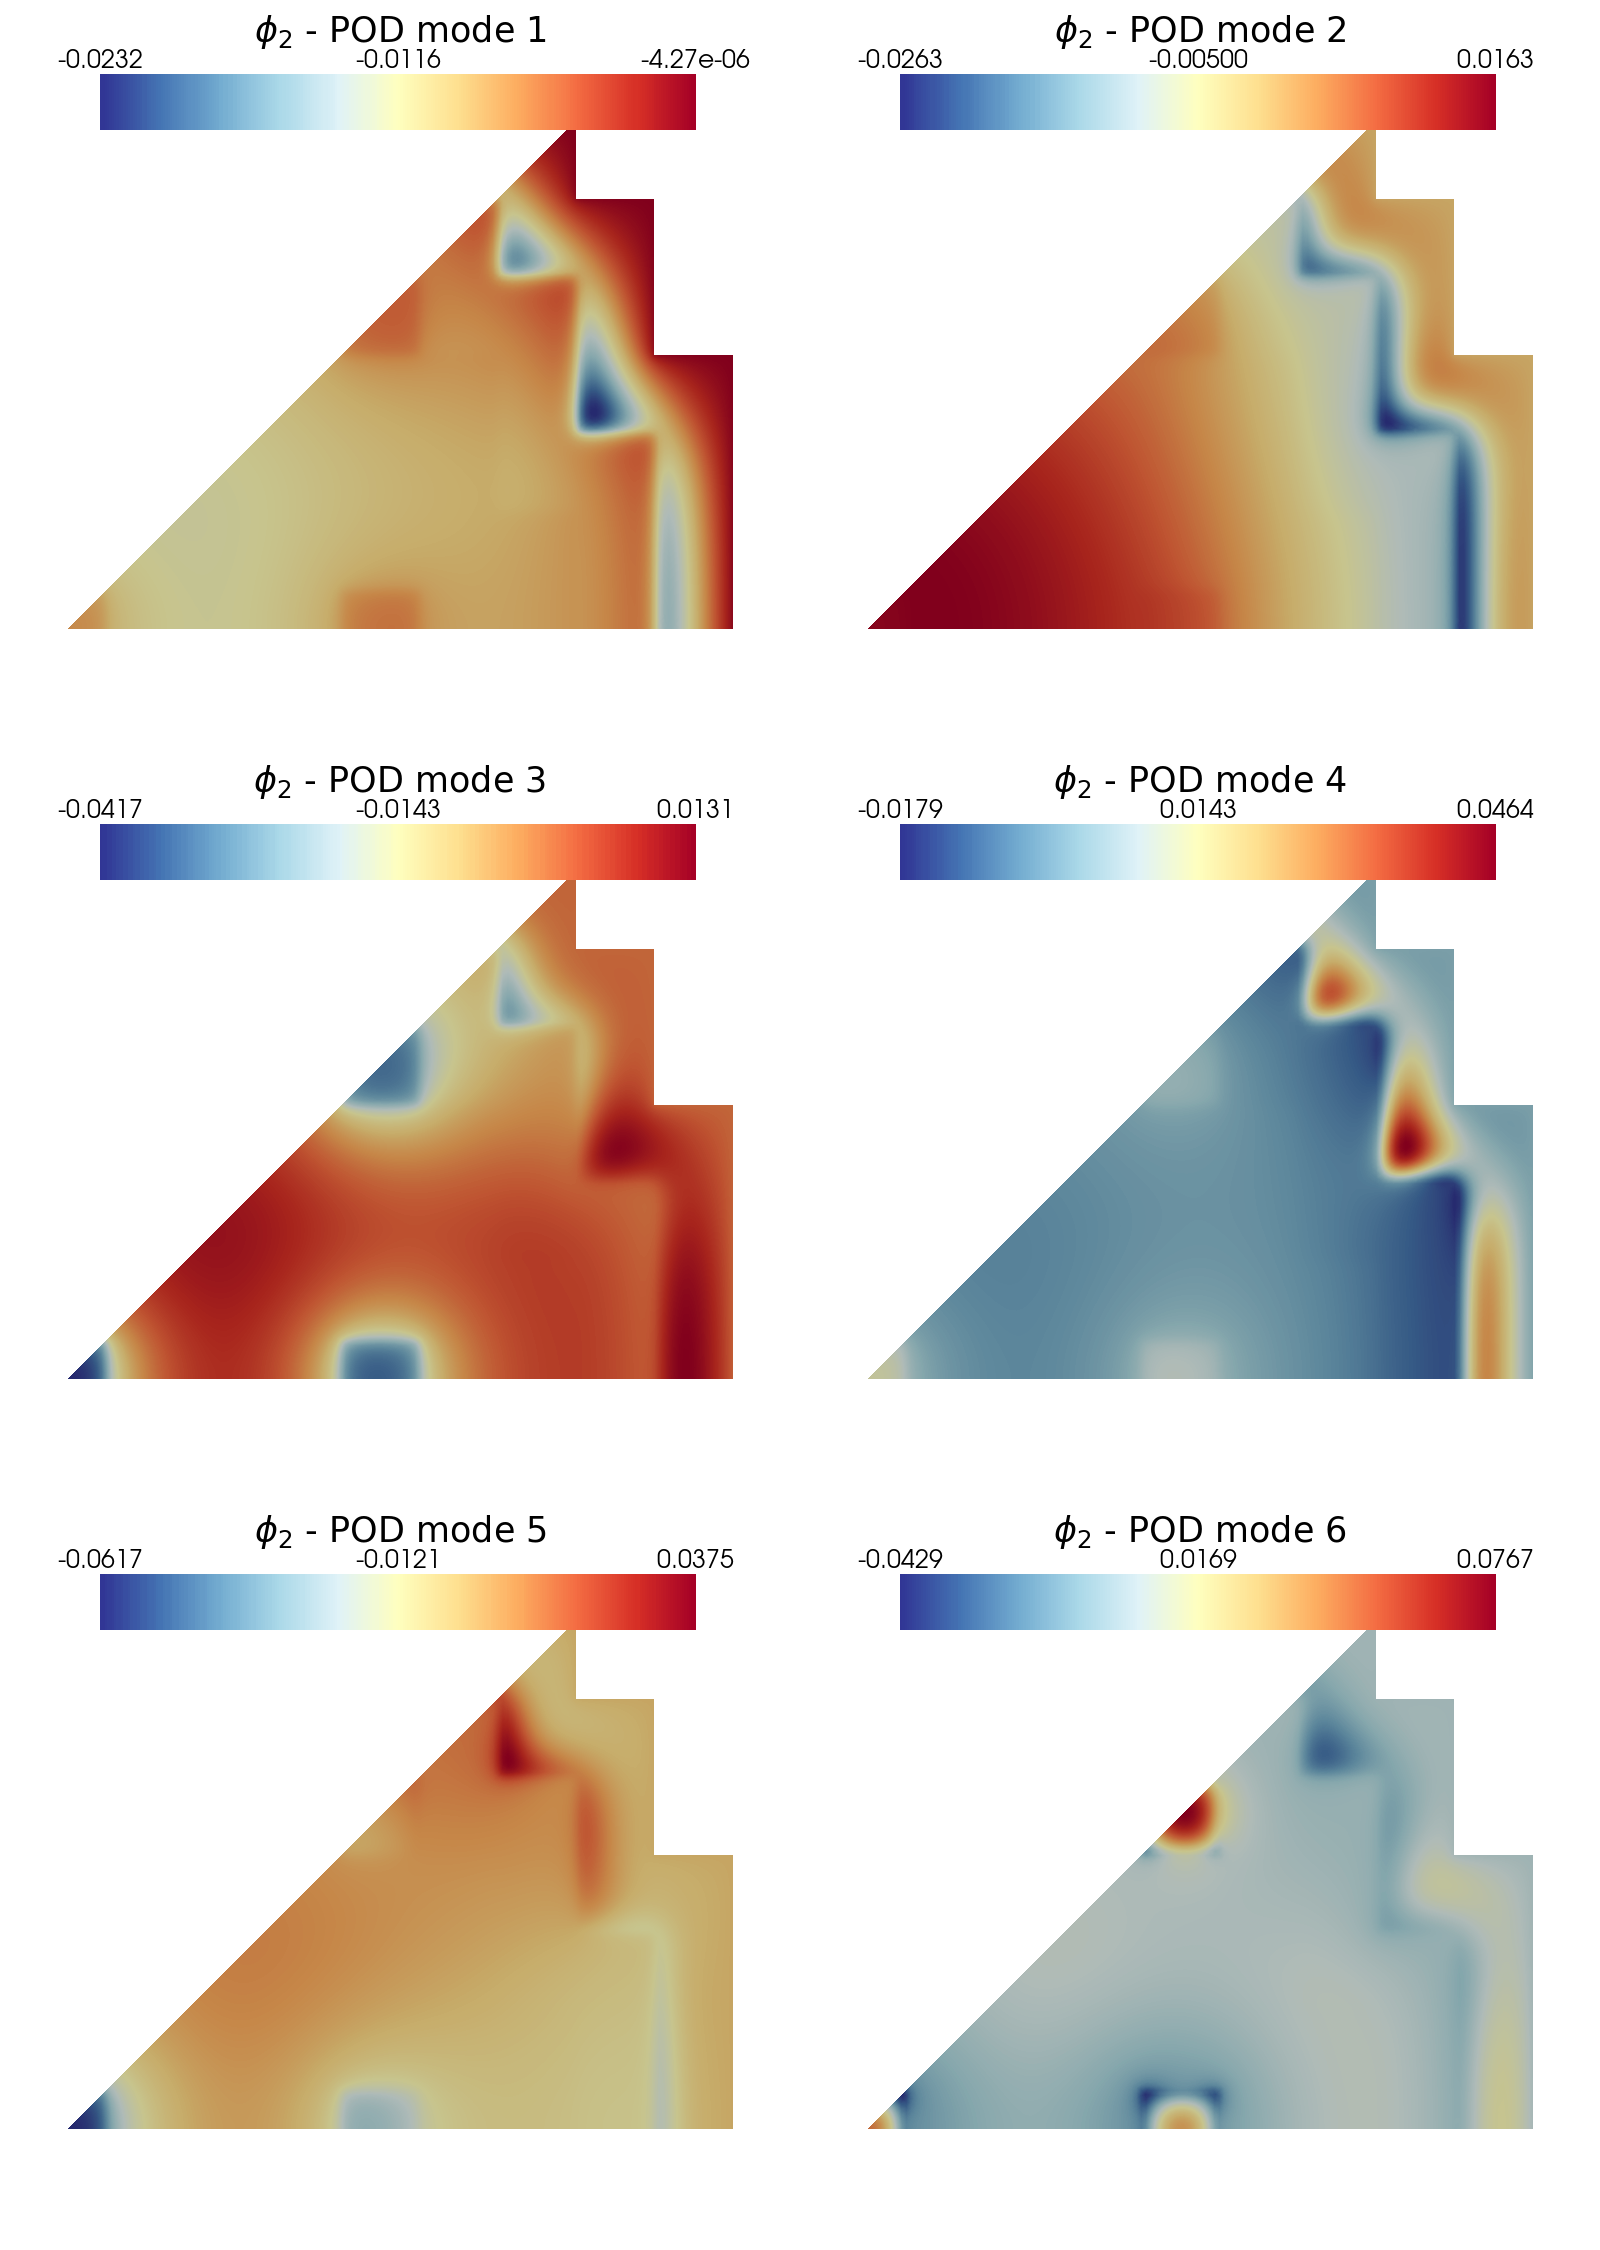

In [16]:
from contour_plotting import plot_modes

plot_modes(pod_data[0].PODmodes, tex_var_names[0], 
           shape = [3,2], colormap=cm.PiYG, title = 'POD mode')
plot_modes(pod_data[1].PODmodes, tex_var_names[1], 
           shape = [3,2], colormap=cm.RdYlBu_r, title = 'POD mode')